# チェックポイント機能：ステートの永続化と再開
LangGraphでのチェックポイント機能とは、ワークフローの実行中に、特定の地点でのステートを「チェックポイント」として保存するためのメカニズムを指す。  
LangGraphでは以下の機能をチェックポイントは持つ：  
* ステートの永続化：ワークフローの実行状態を保存し、あとで同じステートから再開できる
* エラー回復：処理中にエラーが発生した場合、直前のチェックポイントから再開できる
* デバッグ：ワークフローの実行過程を追跡し、問題の原因を特定しやすくする

## チェックポイントのデータ構造
チェックポイントは、図のように、LangGraphの処理ステップが進むたびに`CheckpointTuple`とうデータ構造で保存される。


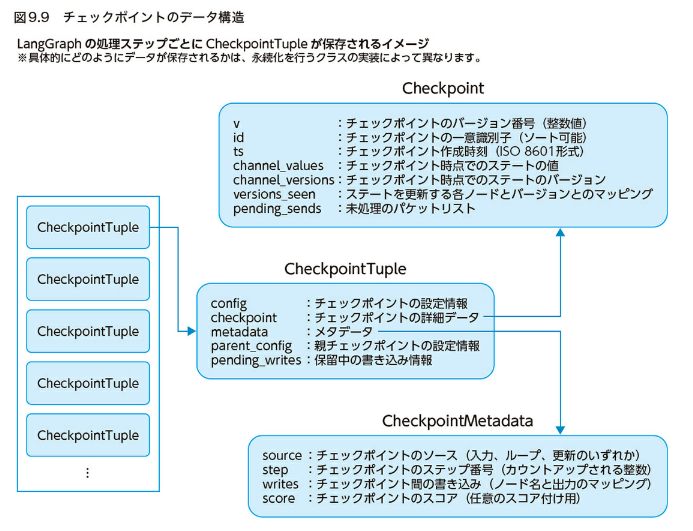

In [1]:
from IPython.display import Image
Image("/content/drive/MyDrive/for_study_in_library/study_LangGraph/png/check_point.png")



CheckpointTuple(表9.1)はステートの具体的な情報や、どのような順序で更新されたのかを示す情報としてCheckpoint(表9.2)とCheckpointMetadata(表9.3)を保持している。

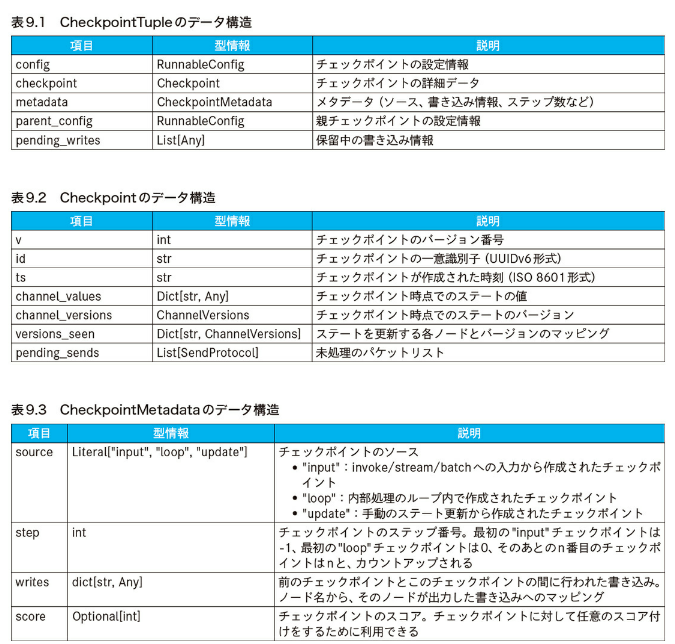

In [2]:
from IPython.display import Image
Image("/content/drive/MyDrive/for_study_in_library/study_LangGraph/png/check_point_2.png")

これらのデータが具体的にどのように永続化されるかは、チェックポイントを実際に永続化するクラスの実装によって異なる。  
LangGraphでは、組み込みのクラスとして次のチェックポインターがある。利用する際は、`langgraph`パッケージとは別に、個別のパッケージをインストールする必要がある。  
* MemorySaver
    * インメモリにチェックポイントの情報を保存するチェックポインター。チェックポイントの情報は永続化されず、プロセス終了時に消去される。動作確認用としての利用推奨。
    * `langgraph-checkpoint`パッケージをインストールして使用
* SqliteSaver
    * SQLiteデータベースにチェックポイントの情報を保存する。チェックポイントの情報が永続化される。本番では非推奨だが、小規模なシステム運用では十分に利用でｋる
    * `langgraph-checkpoint-sqlite`パッケージをインストールして使用
* PostgresSaver
    * PostgresSQLデータベースにチェックポイントの情報を保存する。本番での利用推奨。
    * `langgraph-checkpoint-postgres`パッケージをインストールして使用

それぞれ、以下のようにクラスをインポートして利用する。

In [ ]:
# インメモリチェックポインター
# pip install langgraph-checkpoint
from langgraph.checkpoint.memory import MemorySaver

# SQLiteチェックポインター
# pip install langgraph-checkpoint-sqlite
from langgraph.checkpoint.sqlite import SqliteSaver

# PostgresSQLチェックポインター
# pip install langgraph-checkpoint-postgres
from langgraph.checkpoint.postgres import PostgresSaver

以下は、チェックポインターから呼び出せる情報取得関数

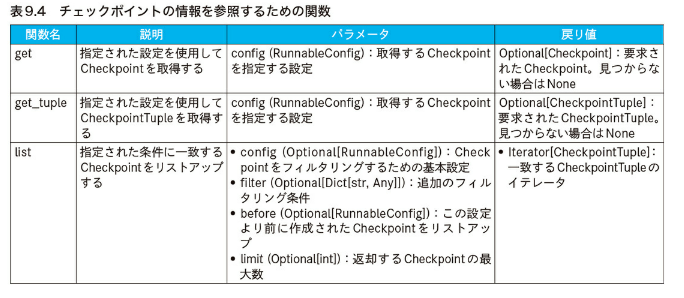

In [3]:
from IPython.display import Image
Image("/content/drive/MyDrive/for_study_in_library/study_LangGraph/png/check_point_3.png")

# チェックポイントの動作確認
* MemorySaverを利用してチェックポイントの動きを確認する

In [1]:
# !pip install langgraph-checkpoint==1.0.11
# !pip install langchain==0.3.0 langchain-openai==0.2.0 langgraph==0.2.22

In [2]:
# import os

# os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
# os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY
# os.environ["LANGCHAIN_PROJECT"] = LANGCHAIN_PROJECT

In [1]:
from dotenv import load_dotenv
load_dotenv()

## グラフのステートとノード関数の定義

In [3]:
import operator
from typing import Annotated, Any
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field

In [4]:
# グラフのステートを定義
class State(BaseModel):
    query: str
    messages: Annotated[list[BaseMessage], operator.add] = Field(default=[])

# メッセージを追加するノード関数
def add_message(state: State) -> dict[str, Any]:
    """
    受け取ったqueryをmessagesに追加して返す関数
    """
    additional_messages = []
    if not state.messages:
        # 初期設定
        additional_messages.append(
            SystemMessage(content="あなたは最小限の応答をする対話エージェントです。")
        )
    additional_messages.append(HumanMessage(content=state.query))

    return {"messages": additional_messages}


# LLMからの応答
def llm_response(state: State) -> dict[str, Any]:
    """
    messagesの内容を元にLLMが応答を生成する関数
    """
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.5)

    ai_message = llm.invoke(state.messages)

    return {"messages": [ai_message]}

## チェックポイントの内容を表示する関数

In [5]:
from pprint import pprint
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.base import BaseCheckpointSaver

In [6]:
def print_checkpoint_dump(checkpointer: BaseCheckpointSaver, config: RunnableConfig):
    """
    チェックポインターのインスタンスから最新のCheckpointTupleを取得し、CheckpointTupleで保存している
    Checkpointの情報とCheckpointMetadataの情報を表示する関数
    """
    checkpoint_tuple = checkpointer.get_tuple(config)

    print("チェックポイントデータ：")
    pprint(checkpoint_tuple.checkpoint)
    print("\nメタデータ：")
    pprint(checkpoint_tuple.metadata)

## グラフの定義とコンパイル

In [7]:
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import MemorySaver

In [9]:
# グラフを設定
graph = StateGraph(State)
graph.add_node("add_message", add_message)
graph.add_node("llm_response", llm_response)

graph.set_entry_point("add_message")

graph.add_edge("add_message", "llm_response")
graph.add_edge("llm_response", END)

# ※※※チェックポインターを設定
checkpointer = MemorySaver()

# グラフをコンパイル
compiled_graph = graph.compile(checkpointer=checkpointer)

## 実行確認

In [11]:
config = {"configurable": {"thread_id": "example-1"}}

user_query = State(query="私の好きなものはずんだ餅です。覚えておいてね。")

first_response = compiled_graph.invoke(user_query, config)
first_response

{'query': '私の好きなものはずんだ餅です。覚えておいてね。',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--1347ed87-a211-4d29-861c-6fcb628a66d2-0', usage_metadata={'input_tokens': 48, 'output_tokens': 10, 'total_tokens': 58})]}

* 第２引数の`thread_id`オプションは、グラフ同士の実行セッションを区別するために設定

<br>

以下で、チェックポインターに対してlist関数を利用し、どのようにチェックポイントの情報が変化しているか確認

In [12]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f057076-5adc-6b0e-8002-4cee8ebd096b'}}, checkpoint={'v': 1, 'ts': '2025-07-02T05:42:53.076121+00:00', 'id': '1f057076-5adc-6b0e-8002-4cee8ebd096b', 'channel_values': {'query': '私の好きなものはずんだ餅です。覚えておいてね。', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'log

以下で、最新のチェックポイントの詳細データを取得

In [13]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ：
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--1347ed87-a211-4d29-861c-6fcb628a66d2-0', usage_metadata={'input_tokens': 48, 'output_tokens': 10, 'total_tokens': 58})],
              

再度、グラフを実行。`invoke`関数の引数には、過去のやりとりの記憶を試す質問を設定。

In [14]:
user_query = State(query="私の好物が何か覚えている？")
second_response = compiled_graph.invoke(user_query, config)
second_response

{'query': '私の好物が何か覚えている？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
  AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--1347ed87-a211-4d29-861c-6fcb628a66d2-0', usage_metadata={'input_tokens': 48, 'output_tokens': 10, 'total_tokens': 58}),
  HumanMessage(content='私の好物が何か覚えている？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='はい、ずんだ餅です。', additional_kwar

Checkpointの`channel_values`の内容確認

In [15]:
for checkpoint in checkpointer.list(config):
    print(checkpoint)

CheckpointTuple(config={'configurable': {'thread_id': 'example-1', 'checkpoint_ns': '', 'checkpoint_id': '1f057083-afe9-67cc-8006-e20412fc3b56'}}, checkpoint={'v': 1, 'ts': '2025-07-02T05:48:50.960355+00:00', 'id': '1f057083-afe9-67cc-8006-e20412fc3b56', 'channel_values': {'query': '私の好物が何か覚えている？', 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}), HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}), AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': No

In [16]:
print_checkpoint_dump(checkpointer, config)

チェックポイントデータ：
{'channel_values': {'llm_response': 'llm_response',
                    'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
                                 HumanMessage(content='私の好きなものはずんだ餅です。覚えておいてね。', additional_kwargs={}, response_metadata={}),
                                 AIMessage(content='了解しました。ずんだ餅ですね。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 48, 'total_tokens': 58, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--1347ed87-a211-4d29-861c-6fcb628a66d2-0', usage_metadata={'input_tokens': 48, 'output_tokens': 10, 'total_tokens': 58}),
               

このように、チェックポイント機能を使うことで、ステートの永続化が可能になる。  

また、`thread_id`を変えて実行した場合は以下のようになる。

In [17]:
config = {"configurable": {"thread_id": "example-2"}}
user_query = State(query="私の好物は？")

other_thread_response = compiled_graph.invoke(user_query, config)
other_thread_response

{'query': '私の好物は？',
 'messages': [SystemMessage(content='あなたは最小限の応答をする対話エージェントです。', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='私の好物は？', additional_kwargs={}, response_metadata={}),
  AIMessage(content='わかりません。あなたの好物は何ですか？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 35, 'total_tokens': 49, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'finish_reason': 'stop', 'logprobs': None}, id='run--f6ea3886-b383-4f80-a331-5b7447f85b7c-0', usage_metadata={'input_tokens': 35, 'output_tokens': 14, 'total_tokens': 49})]}

thread_idごとにステートが保存されているため、example-1の会話履歴が読み込まれていないことがわかる。